In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numexpr
%matplotlib inline
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = [8, 6]

## Prepare experimental data

In [259]:
lora_mons_static = pd.read_pickle('../data/lora_mons_static_clean.pkl.gz')
channel = lora_mons_static.query('gtw_id == "eui-0000024b08030186"')[['received', 'data_rate', 'dev_id']]
channel['sf'] = channel['data_rate'].str.extract('SF([0-9]+)BW').astype(np.int64)
count_by_sf = channel.groupby(['dev_id', 'sf']).resample('D', on='received').size().unstack('sf', fill_value=0)
count_by_sf = count_by_sf.groupby('dev_id').apply(lambda group: group.iloc[1:-1, :]).droplevel(0)
count_by_sf.head()

sf                                     7   8   9   10  11  12
dev_id      received                                         
static_6_01 2019-04-26 00:00:00+00:00  58  31  14   9   2   3
            2019-04-27 00:00:00+00:00  53  30  15   8   5   2
            2019-04-28 00:00:00+00:00  53  31  18   8   3   2
            2019-04-29 00:00:00+00:00  57  27  15   9   3   2
            2019-04-30 00:00:00+00:00  55  28  15   7   3   2

In [260]:
def insert_packet(spreading_factor):
    if spreading_factor < 7:
        return []
    return insert_packet(spreading_factor - 1) + [spreading_factor] + insert_packet(spreading_factor - 1)

sf_as_category = pd.Categorical(insert_packet(12), categories=[7, 8, 9, 10, 11, 12], ordered=True)
pyramid = pd.DataFrame({'sf': sf_as_category})
pyramid['seq_num'] = pyramid.index
index = pd.timedelta_range(start='0 day', periods=len(pyramid.index) * 100, freq='10 min')
tenminute_sequence = pyramid
for i in range(99):
    tenminute_sequence = tenminute_sequence.append(pyramid)
tenminute_sequence.index = index
daily_count_by_sf = tenminute_sequence[['sf']].groupby('sf').resample('1D').count()[:-1].rename(columns={'sf': 'count'})
daily_count_by_sf.mean(level=0).T

sf,7,8,9,10,11,12
count,72.727273,36.363636,18.181818,9.090909,4.545455,2.302326


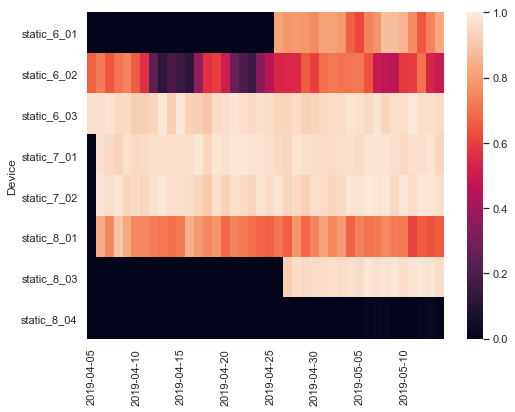

In [274]:
count_by_day = channel.groupby('dev_id').resample('D', on='received').size()
pdr = count_by_day.groupby(level='dev_id').apply(lambda group: group.iloc[1:-1]).droplevel(0).unstack(level='dev_id', fill_value=0) / 24 / 6
pdr.index = pdr.index.date
g = sns.heatmap(pdr.T, vmin=0, vmax=1, xticklabels=5)
g.set(ylabel='Device')
g.figure.savefig('../pdr.png', bbox_inches = 'tight')